## Problem Definition

Given clinical parameters about a patient, can we predict whether or not they have heart disease?

## Data

The original data came from the Cleveland database from UCI Machine Learning Repository.

Howevever, we've downloaded it in a formatted way from Kaggle.

## Importing Packages

In [1]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

#getting data ready
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

#importing classification models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

#model evaluation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve

#imroving hyperparameters
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [2]:
np.random.seed(42)

## Load The Data

In [3]:
df = pd.read_csv("heart-disease.csv")

In [4]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [5]:
len(df), df.shape

(303, (303, 14))

In [6]:
df["target"].value_counts()

1    165
0    138
Name: target, dtype: int64

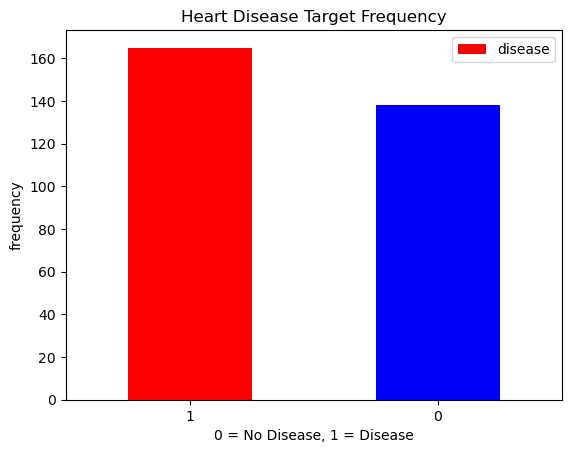

In [7]:
df["target"].value_counts().plot( kind="bar", color=["red", 'blue'])
plt.title("Heart Disease Target Frequency")
plt.xlabel("0 = No Disease, 1 = Disease")
plt.ylabel("frequency")
plt.legend(["disease", "no disease"])
plt.xticks(rotation=0)
plt.show();

In [8]:
df.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

### finding frequent patterns

In [9]:
df["sex"].value_counts()

1    207
0     96
Name: sex, dtype: int64

In [10]:
pd.crosstab(df.target,df.sex)

sex,0,1
target,,
0,24,114
1,72,93


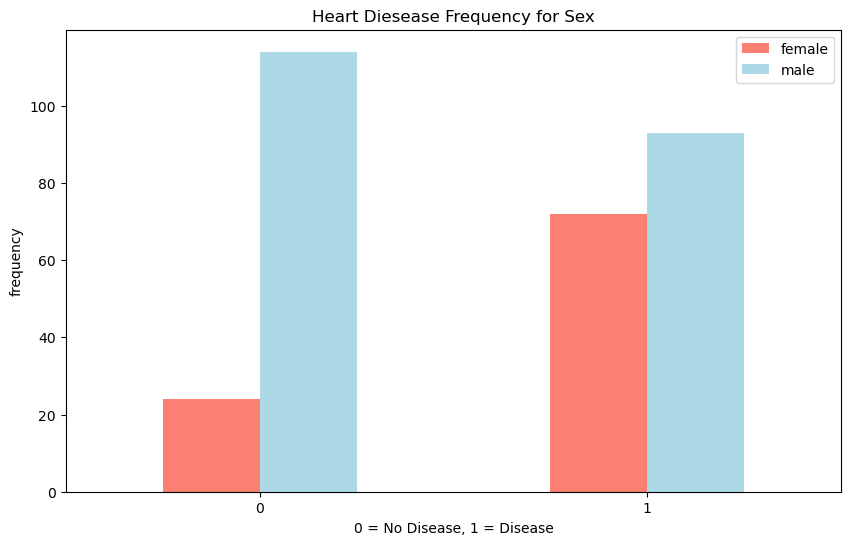

In [11]:
pd.crosstab(df.target,df.sex).plot(kind="bar", figsize=(10,6), color=["salmon", "lightblue"])
plt.title("Heart Diesease Frequency for Sex")
plt.xlabel("0 = No Disease, 1 = Disease")
plt.ylabel("frequency")
plt.legend(["female", "male"])
plt.xticks(rotation=0)
plt.show();

### Age vs Max Heart Rate for Heart Disease

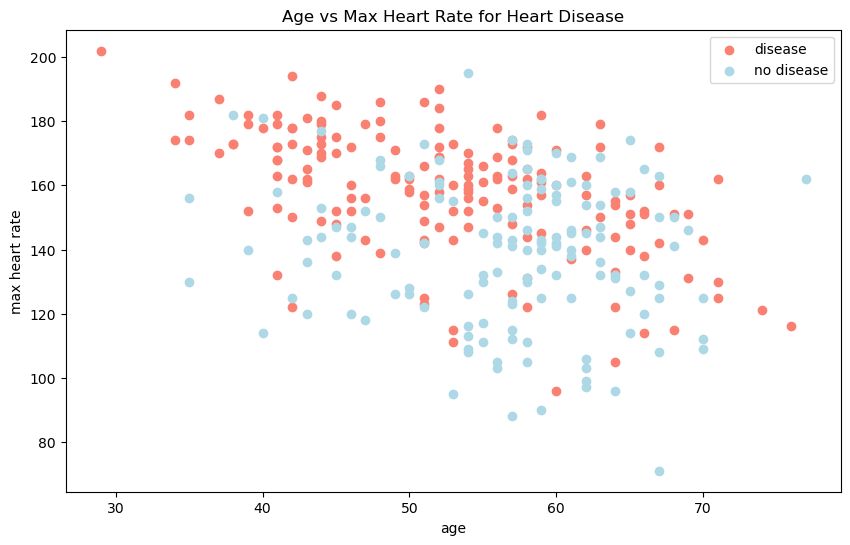

In [12]:
plt.figure(figsize=(10,6))

plt.scatter(df.age[df.target==1], df.thalach[df.target==1], color="salmon")
plt.scatter(df.age[df.target==0], df.thalach[df.target==0], color="lightblue")

plt.title("Age vs Max Heart Rate for Heart Disease")
plt.xlabel("age")
plt.ylabel("max heart rate")
plt.legend(["disease", "no disease"])
plt.show();

### Heart Disease Frequency per Chest Pain Type

In [13]:
df.cp[df.target==1].value_counts()

2    69
1    41
0    39
3    16
Name: cp, dtype: int64

In [14]:
df.cp[df.target==0].value_counts()

0    104
2     18
1      9
3      7
Name: cp, dtype: int64

In [15]:
pd.crosstab(df.cp, df.target)

target,0,1
cp,,
0,104,39
1,9,41
2,18,69
3,7,16


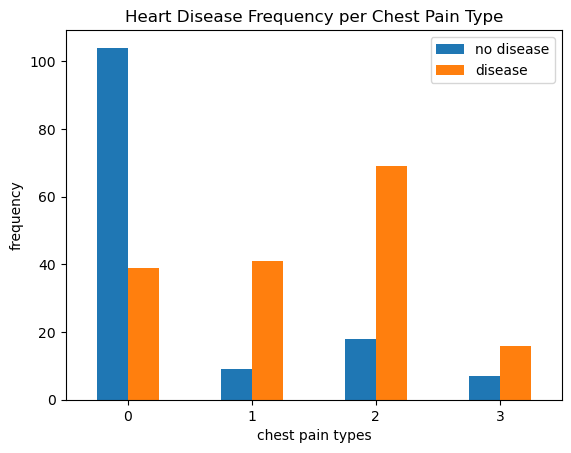

In [16]:
pd.crosstab(df.cp, df.target).plot(kind="bar")

plt.title("Heart Disease Frequency per Chest Pain Type")
plt.xlabel("chest pain types")
plt.ylabel("frequency")
plt.legend(["no disease", "disease"])
plt.xticks(rotation=0)
plt.show();

### corelation matrix

In [17]:
import seaborn as sns

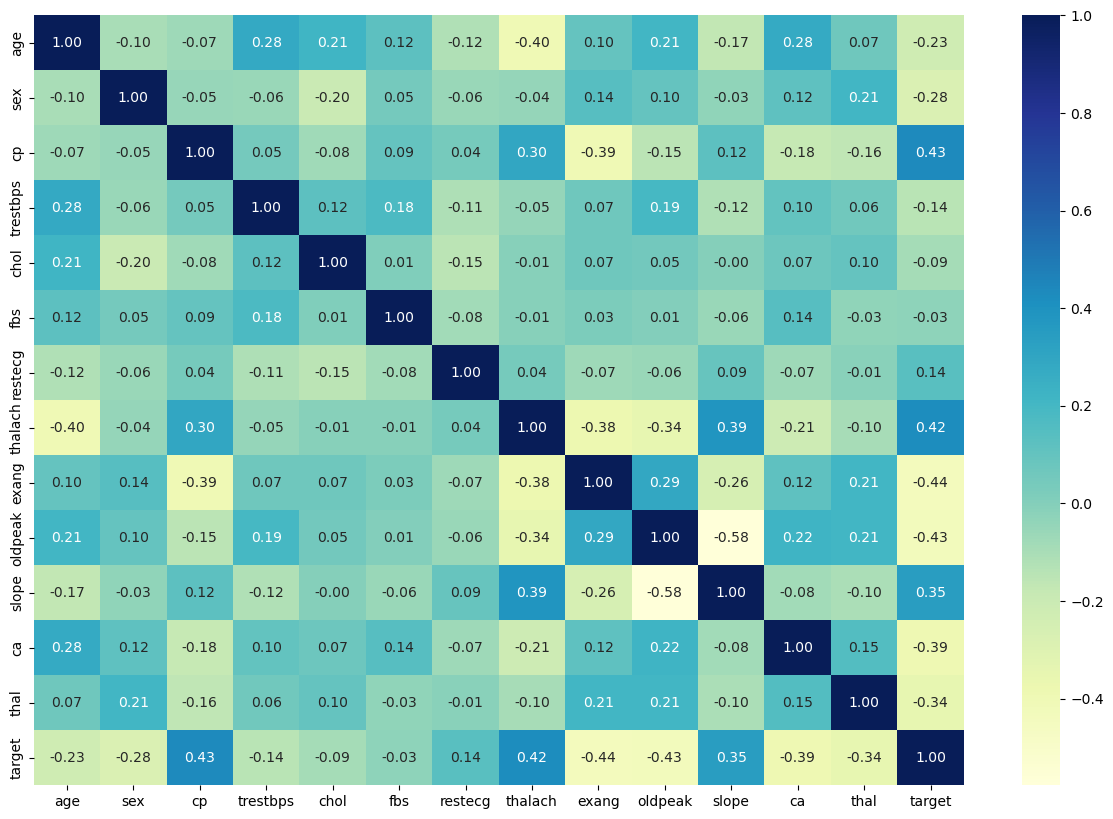

In [18]:
corr_matrix = df.corr()
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="YlGnBu");

## Splitting Data

In [19]:
x = df.drop("target", axis=1)
y = df["target"]

In [20]:
x.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2


In [21]:
y.head()

0    1
1    1
2    1
3    1
4    1
Name: target, dtype: int64

### train test split

In [22]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [23]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((242, 13), (61, 13), (242,), (61,))

In [24]:
x_train.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
132,42,1,1,120,295,0,1,162,0,0.0,2,0,2
202,58,1,0,150,270,0,0,111,1,0.8,2,0,3
196,46,1,2,150,231,0,1,147,0,3.6,1,0,2
75,55,0,1,135,250,0,0,161,0,1.4,1,0,2
176,60,1,0,117,230,1,1,160,1,1.4,2,2,3


## Model Building

In [25]:
models = {"Logistic Regression": LogisticRegression(), 
          "KNN": KNeighborsClassifier(),
          "Random Forest": RandomForestClassifier()}

def fit_and_score(models, x_train, x_test, y_train, y_test):
    np.random.seed(42)
    
    model_scores = {}
    
    for name, model in models.items():
        model.fit(x_train, y_train)
        model_scores[name] = model.score(x_test, y_test)
    
    return model_scores
    

In [26]:
model_scores = fit_and_score(models, x_train, x_test, y_train, y_test)
model_scores

C:\Users\DELL\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this 

{'Logistic Regression': 0.8852459016393442,
 'KNN': 0.6885245901639344,
 'Random Forest': 0.8360655737704918}

In [27]:
model_compare = pd.DataFrame(model_scores, index=["accuracy"])
model_compare

,Logistic Regression,KNN,Random Forest
accuracy,0.885246,0.688525,0.836066


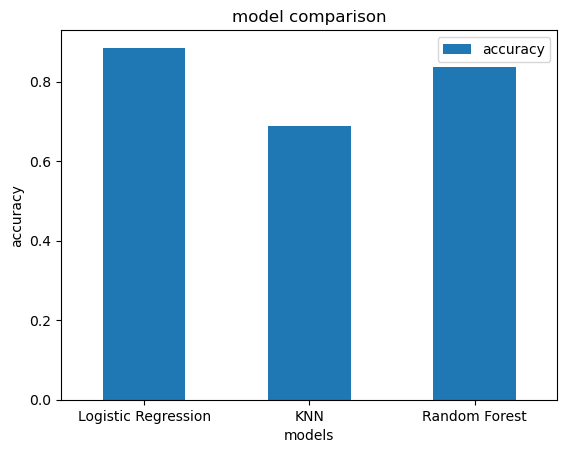

In [28]:
model_compare.T.plot(kind="bar")
plt.title("model comparison")
plt.xlabel("models")
plt.ylabel("accuracy")
plt.xticks(rotation=0)
plt.show();

### Tuning KNN Hyperparameters

In [29]:
train_scores = []
test_scores = []

neighbors = range(1,21)

knn = KNeighborsClassifier()

for i in neighbors:
    knn.set_params(n_neighbors=i)
    knn.fit(x_train, y_train)
    train_scores.append(knn.score(x_train, y_train))
    test_scores.append(knn.score(x_test, y_test))
    

C:\Users\DELL\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

C:\Users\DELL\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

C:\Users\DELL\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

In [30]:
train_scores

[1.0,
 0.8099173553719008,
 0.7727272727272727,
 0.743801652892562,
 0.7603305785123967,
 0.7520661157024794,
 0.743801652892562,
 0.7231404958677686,
 0.71900826446281,
 0.6942148760330579,
 0.7272727272727273,
 0.6983471074380165,
 0.6900826446280992,
 0.6942148760330579,
 0.6859504132231405,
 0.6735537190082644,
 0.6859504132231405,
 0.6652892561983471,
 0.6818181818181818,
 0.6694214876033058]

In [31]:
test_scores

[0.6229508196721312,
 0.639344262295082,
 0.6557377049180327,
 0.6721311475409836,
 0.6885245901639344,
 0.7213114754098361,
 0.7049180327868853,
 0.6885245901639344,
 0.6885245901639344,
 0.7049180327868853,
 0.7540983606557377,
 0.7377049180327869,
 0.7377049180327869,
 0.7377049180327869,
 0.6885245901639344,
 0.7213114754098361,
 0.6885245901639344,
 0.6885245901639344,
 0.7049180327868853,
 0.6557377049180327]

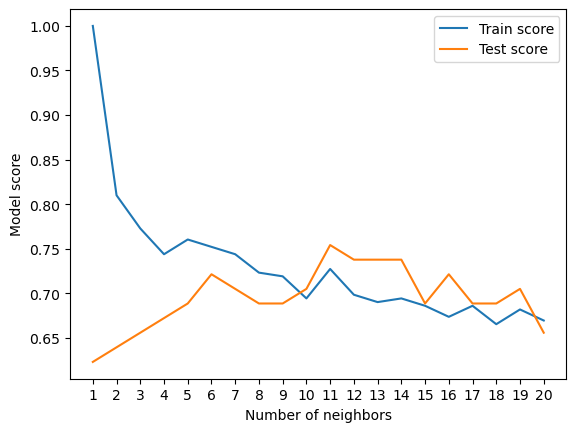

Maximum test score on test data: 75.41%


In [32]:
plt.plot(neighbors, train_scores, label="Train score")
plt.plot(neighbors, test_scores, label="Test score")
plt.xlabel("Number of neighbors")
plt.ylabel("Model score")
plt.xticks(range(1,21,1))
plt.legend()
plt.show();

print(f"Maximum test score on test data: {max(test_scores)*100:.2f}%")

### HyperTuning For Logistic and RandomClassifier using RandomizedSearchCV

In [33]:
log_reg_grid = {"C":np.logspace(-4, 4, 20), "solver": ["liblinear"]}

rf_grid = {"n_estimators": np.arange(10,1000,50),
           "max_depth": [None, 3, 5,  10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20,2)}

In [34]:
np.random.seed(42)

rs_log_reg = RandomizedSearchCV(LogisticRegression(), param_distributions=log_reg_grid, cv=5, n_iter=20, verbose=True)

rs_log_reg.fit(x_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=20,
                   param_distributions={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                        'solver': ['liblinear']},
                   verbose=True)

In [35]:
rs_log_reg.best_params_

{'solver': 'liblinear', 'C': 0.23357214690901212}

In [36]:
rs_log_reg.score(x_test, y_test)

0.8852459016393442

In [37]:
np.random.seed(42)

rs_rf = RandomizedSearchCV(RandomForestClassifier(), param_distributions=rf_grid, cv=5, n_iter=20, verbose=True)

rs_rf.fit(x_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([ 10,  60, 110, 160, 210, 260, 310, 360, 410, 460, 510, 560, 610,
       660, 710, 760, 810, 860, 910, 960])},
                   verbose=True)

In [38]:
rs_rf.best_params_

{'n_estimators': 210,
 'min_samples_split': 4,
 'min_samples_leaf': 19,
 'max_depth': 3}

In [39]:
rs_rf.score(x_test, y_test)

0.8688524590163934

### HyperTuning For Logistic using GridSearchCV

In [40]:
log_reg_grid = {"C":np.logspace(-4, 4, 30), "solver": ["liblinear"]}

gs_log_reg = GridSearchCV(LogisticRegression(), param_grid=log_reg_grid, cv=5, verbose=True)

gs_log_reg.fit(x_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([1.00000000e-04, 1.88739182e-04, 3.56224789e-04, 6.72335754e-04,
       1.26896100e-03, 2.39502662e-03, 4.52035366e-03, 8.53167852e-03,
       1.61026203e-02, 3.03919538e-02, 5.73615251e-02, 1.08263673e-01,
       2.04335972e-01, 3.85662042e-01, 7.27895384e-01, 1.37382380e+00,
       2.59294380e+00, 4.89390092e+00, 9.23670857e+00, 1.74332882e+01,
       3.29034456e+01, 6.21016942e+01, 1.17210230e+02, 2.21221629e+02,
       4.17531894e+02, 7.88046282e+02, 1.48735211e+03, 2.80721620e+03,
       5.29831691e+03, 1.00000000e+04]),
                         'solver': ['liblinear']},
             verbose=True)

In [41]:
gs_log_reg.best_params_

{'C': 0.20433597178569418, 'solver': 'liblinear'}

In [42]:
gs_log_reg.score(x_test, y_test)

0.8852459016393442

### Evaluating tuned machine learning

In [43]:
y_preds = gs_log_reg.predict(x_test)

In [44]:
y_preds

array([0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0], dtype=int64)

In [45]:
y_test

179    0
228    0
111    1
246    0
60     1
      ..
249    0
104    1
300    0
193    0
184    0
Name: target, Length: 61, dtype: int64

C:\Users\DELL\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


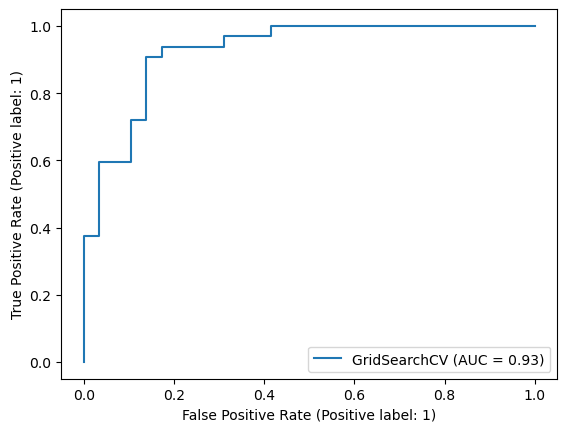

In [50]:
plot_roc_curve(gs_log_reg, x_test, y_test);

In [51]:
confusion_matrix(y_test, y_preds)

array([[25,  4],
       [ 3, 29]], dtype=int64)

In [52]:
pd.crosstab(y_test, y_preds, rownames=["Actual Labels"], colnames=["Predicted Labels"])

Predicted Labels,0,1
Actual Labels,,
0,25,4
1,3,29


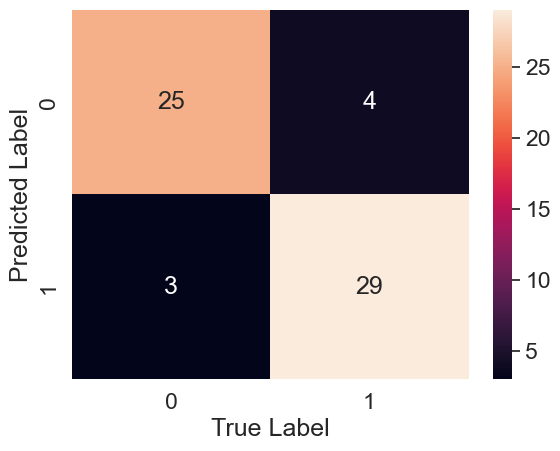

In [54]:
import seaborn as sns

sns.set(font_scale = 1.5)
sns.heatmap(confusion_matrix(y_test, y_preds), annot=True)
plt.xlabel("True Label")
plt.ylabel("Predicted Label");

In [55]:
classification_report(y_test, y_preds)

'              precision    recall  f1-score   support\n\n           0       0.89      0.86      0.88        29\n           1       0.88      0.91      0.89        32\n\n    accuracy                           0.89        61\n   macro avg       0.89      0.88      0.88        61\nweighted avg       0.89      0.89      0.89        61\n'

### calculate evaluation using cross-validation

In [56]:
gs_log_reg.best_params_

{'C': 0.20433597178569418, 'solver': 'liblinear'}

In [59]:
clf = LogisticRegression(C=0.20433597178569418, solver='liblinear')

In [73]:
cv_accuracy = np.mean(cross_val_score(clf, x, y, cv=5, scoring="accuracy"))
cv_accuracy

0.8446994535519124

In [74]:
cv_precision = np.mean(cross_val_score(clf, x, y, cv=5, scoring="precision"))
cv_precision

0.8207936507936507

In [75]:
cv_recall = np.mean(cross_val_score(clf, x, y, cv=5, scoring="recall"))
cv_recall

0.9212121212121213

In [76]:
cv_f1 = np.mean(cross_val_score(clf, x, y, cv=5, scoring="f1"))
cv_f1

0.8673007976269721

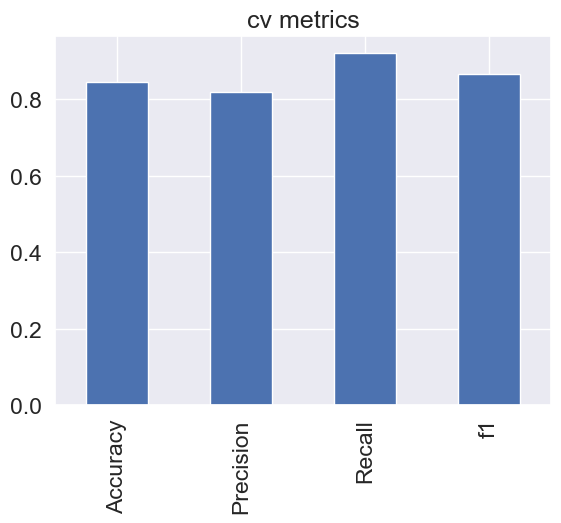

In [78]:
cv_metrics = pd.DataFrame({"Accuracy": cv_accuracy, "Precision": cv_precision, "Recall": cv_recall, "f1": cv_f1}, index=[0])
cv_metrics.T.plot.bar(title="cv metrics", legend=False);


### Feature importance

In [80]:
clf = LogisticRegression(C=0.20433597178569418, solver='liblinear')
clf.fit(x_train, y_train)

LogisticRegression(C=0.20433597178569418, solver='liblinear')

In [81]:
clf.coef_

array([[ 0.00316728, -0.86044651,  0.66067041, -0.01156993, -0.00166374,
         0.04386107,  0.31275847,  0.02459361, -0.6041308 , -0.56862804,
         0.45051628, -0.63609897, -0.67663373]])

In [83]:
feature_dict = dict(zip(df.columns, list(clf.coef_[0])))
feature_dict

{'age': 0.0031672801993431563,
 'sex': -0.8604465072345515,
 'cp': 0.6606704082033799,
 'trestbps': -0.01156993168080875,
 'chol': -0.001663744504776871,
 'fbs': 0.043861071652469864,
 'restecg': 0.31275846822418324,
 'thalach': 0.024593613737779126,
 'exang': -0.6041308000615746,
 'oldpeak': -0.5686280368396555,
 'slope': 0.4505162797258308,
 'ca': -0.6360989676086223,
 'thal': -0.6766337263029825}

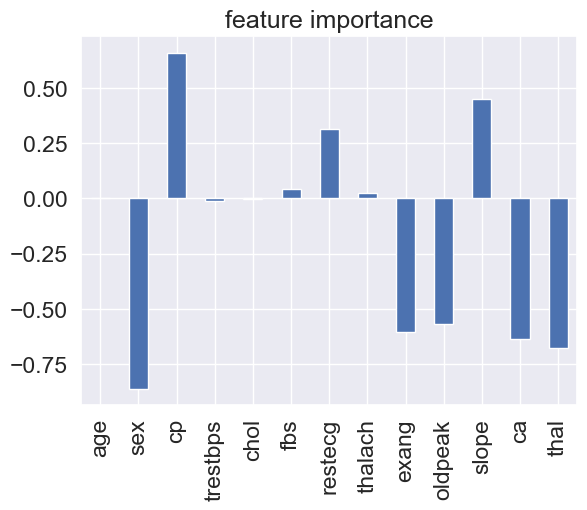

In [84]:
feature_df = pd.DataFrame(feature_dict, index=[0])
feature_df.T.plot.bar(title="feature importance", legend=False);